In [50]:
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
# from matplotlib import cm

path_to_add = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if path_to_add not in sys.path:
    sys.path.insert(0, path_to_add)

from rsimpy.cmg.sr3reader import Sr3Reader

In [51]:
test_file = "../sr3/mini_section/base_case_bo_section.sr3"
sr3 = Sr3Reader(test_file)
dataset = sr3.file.get_table("SpatialProperties/000000/GRID")

# Cell Connections

In [52]:
def _get_connections(sr3):
    """Get all cell connections from the SR3 file.

    Returns:
    --------
    connections: np.ndarray
        Array with shape (n_connections, 3) where each row contains the two
        connected cells ("+" face and "-" face) and the connection type
        (1=I, 2=J, 3=K, 4=Mat-Frac). For connections with type 4, the
        cell order is matrix cell and fracture cell.
    """
    con_type = sr3.file.get_table("SpatialProperties/000000/GRID/ICNTDR")[:]
    cell1 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS1")[:]
    cell2 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS2")[:]

    cell1_ = sr3.grid.active2complete(cell1)
    cell2_ = sr3.grid.active2complete(cell2)

    ijk1 = sr3.grid.n2ijk(cell1_)
    ijk2 = sr3.grid.n2ijk(cell2_)

    downstream = ijk1[np.arange(ijk1.shape[0]),con_type-1] <= ijk2[np.arange(ijk2.shape[0]),con_type-1]

    connections = np.zeros((len(cell1_), 3), dtype=cell1_.dtype)
    connections[downstream] = np.column_stack((cell1_[downstream], cell2_[downstream], con_type[downstream]))
    connections[~downstream] = np.column_stack((cell2_[~downstream], cell1_[~downstream], con_type[~downstream]))

    return connections

connections = _get_connections(sr3)
connections

array([[3, 4, 2],
       [6, 3, 2],
       [3, 7, 3],
       [4, 8, 3],
       [5, 6, 2],
       [6, 7, 2],
       [7, 8, 2]], dtype=int32)

## Cell Coordinates

In [53]:
blocks = sr3.file.get_table("SpatialProperties/000000/GRID/BLOCKS")[:].reshape(-1, 8)
nodes = sr3.file.get_table("SpatialProperties/000000/GRID/NODES")[:].reshape(-1, 3)

In [54]:
EPSILON = 1e-2

In [55]:
def _get_nodes(cell, face=None):
    """Get coordinates of nodes of a cell or cells.

    The cell numbering is as follows:
                K-
            1--------2            x--> I
           /|       /|           /|
          / |      / |          / |
         /  |  J- /  |         v  v
        0--------3   |        J   K
        |   |    |   |
    I-  |   5----|---6  I+
        |  / J+  |  /
        | /      | /
        |/       |/
        4--------7
           K+

    Nodes are ordered in the faces so that the normal vector points
    in the same direction as the coordinate system.

    Parameters
    ----------
    cell : int, list of int or np.ndarray
        Cell number(s) (complete).
    face : int, str or None
        Face of the cell. If None, all nodes of the cell are returned.
        Valid values are "I-", "I+", "J-", "J+", "K-", "K+", or
        0, 1, 2, 3, 4, 5 for I-, I+, J-, J+, K-, K+, respectively.

    Returns
    -------
    np.ndarray
        Coordinates of nodes of the cell(s).
    """
    if isinstance(cell, (int, np.integer)):
        cell = np.array([cell])
    elif isinstance(cell, list):
        cell = np.array(cell)

    if face is None:
        edge_n = [0, 1, 2, 3, 4, 5, 6, 7]
    elif face == "I-" or face==0:
        edge_n = [1, 5, 6, 2]
    elif face == "I+" or face==1:
        edge_n = [0, 4, 7, 3]
    elif face == "J-" or face==2:
        edge_n = [0, 4, 5, 1]
    elif face == "J+" or face==3:
        edge_n = [3, 7, 6, 2]
    elif face == "K-" or face==4:
        edge_n = [0, 1, 2, 3]
    elif face == "K+" or face==5:
        edge_n = [4, 5, 6, 7]
    else:
        raise ValueError(f"Invalid face: {face}.")

    return nodes[blocks[cell-1][:,edge_n]-1]

_get_nodes([4,3], "I-")

array([[[1739.5813, 9416.2911, 5494.1958],
        [1739.3762, 9416.4063, 5496.6265],
        [1718.5998, 9218.0801, 5464.9932],
        [1718.9533, 9217.9083, 5461.7588]],

       [[1761.5315, 9614.4522, 5528.7559],
        [1761.4494, 9614.5098, 5530.0557],
        [1739.3762, 9416.4063, 5496.6265],
        [1739.5813, 9416.2911, 5494.1958]]])

In [56]:
def _get_center(cell, face=None):
    return np.mean(_get_nodes(cell, face), axis=1)

_get_center([4,3], "I-")

array([[1729.12765 , 9317.17145 , 5479.393575],
       [1750.4846  , 9515.41485 , 5512.408475]])

In [57]:
def _get_intersection(line1, line2, tolerance=EPSILON):
    """
    Find the closest point between two lines in 3D.

    Parameters:
    line1, line2: Lines defined by two points. (numpy arrays of shape (2, 3))

    Returns:
    closest_point: The closest point to both lines (numpy array of shape (3,))
    """
    p1 = line1[0]
    p2 = line2[0]
    d1 = line1[1] - line1[0]
    d2 = line2[1] - line2[0]

    d1 = d1 / np.linalg.norm(d1)
    d2 = d2 / np.linalg.norm(d2)
    cross_d1_d2 = np.cross(d1, d2)

    if np.linalg.norm(cross_d1_d2) == 0:
        raise ValueError("The lines are parallel and do not intersect.")

    p2_p1 = p2 - p1

    cross_d1_d2_norm_sqr = np.linalg.norm(cross_d1_d2)**2
    t1 = np.linalg.det([p2_p1, d2, cross_d1_d2]) / cross_d1_d2_norm_sqr
    t2 = np.linalg.det([p2_p1, d1, cross_d1_d2]) / cross_d1_d2_norm_sqr

    closest_point_on_line1 = p1 + t1 * d1
    closest_point_on_line2 = p2 + t2 * d2

    if np.linalg.norm(closest_point_on_line1 - closest_point_on_line2) > tolerance:
        raise ValueError("The lines are skew and do not intersect.")

    closest_point = (closest_point_on_line1 + closest_point_on_line2) / 2
    return closest_point

In [58]:
def _get_nnc_face(face1, face2):
    """Get the coordinates of the nodes of the non-neighbor connection face."""
    faces = np.stack((face1[0], face2[0]), axis=0)

    limits = faces[0][:,2] > faces[1][:,2]

    top_left = faces[1-limits[0]][0]
    bottom_left = faces[0+limits[1]][1]
    bottom_right = faces[0+limits[2]][2]
    top_right = faces[1-limits[3]][3]


    checks = [
        top_left[2] <= bottom_left[2],
        limits[0] == limits[3],
        top_right[2] <= bottom_right[2],
        limits[1] == limits[2],
    ]

    if not np.any(checks):
        raise ValueError("Faces are not connected.")

    face_nodes = []
    if checks[0]:
        face_nodes.append(bottom_left)
        face_nodes.append(top_left)
    else:
        face_nodes.append(_get_intersection(
            faces[1-limits[0]][[0,3]],
            faces[0+limits[1]][[1,2]]
            ))

    if not checks[1]:
        face_nodes.append(_get_intersection(
            faces[0][[0,3]],
            faces[1][[0,3]]
            ))

    if checks[2]:
        face_nodes.append(top_right)
        face_nodes.append(bottom_right)
    else:
        face_nodes.append(_get_intersection(
            faces[0+limits[2]][[1,2]],
            faces[1-limits[3]][[0,3]]
            ))

    if not checks[3]:
        face_nodes.append(_get_intersection(
            faces[0][[1,2]],
            faces[1][[1,2]]
            ))

    return np.stack(face_nodes, axis=0)

In [59]:
def _get_common_face(connection):
    cell1, cell2, con_type = connection

    face1_index = 2*con_type - 1
    face2_index = 2*con_type - 2

    face1 = _get_nodes(cell1, face1_index)
    face2 = _get_nodes(cell2, face2_index)

    if np.all(np.linalg.norm(face1[0] - face2[0], axis=1) < EPSILON):
        return face1[0]

    if con_type == 3:
            raise ValueError("Faces are not aligned in K direction.")

    return _get_nnc_face(face1, face2)

_get_common_face(connections[1])

array([[1797.92898881, 9610.09537679, 5531.81233636],
       [1761.4953    , 9614.4776    , 5529.3247    ],
       [1761.4494    , 9614.5098    , 5530.0557    ]])

In [60]:
for c in connections:
    print(c)
    print(_get_common_face(c))

[3 4 2]
[[1934.6487 9392.085  5503.563 ]
 [1934.5569 9392.1485 5505.0625]
 [1739.3762 9416.4063 5496.6265]
 [1739.5813 9416.2911 5494.1958]]
[6 3 2]
[[1797.92898881 9610.09537679 5531.81233636]
 [1761.4953     9614.4776     5529.3247    ]
 [1761.4494     9614.5098     5530.0557    ]]
[3 7 3]
[[1956.3928 9590.9219 5539.4429]
 [1761.4494 9614.5098 5530.0557]
 [1739.3762 9416.4063 5496.6265]
 [1934.5569 9392.1485 5505.0625]]
[4 8 3]
[[1934.5569 9392.1485 5505.0625]
 [1739.3762 9416.4063 5496.6265]
 [1718.5998 9218.0801 5464.9932]
 [1913.0129 9194.1446 5472.3262]]
[5 6 2]
[[1978.2463 9791.2598 5583.7827]
 [1978.2463 9791.2598 5583.7827]
 [1782.4367 9813.5372 5572.1289]
 [1782.5637 9813.4493 5570.1582]]
[6 7 2]
[[1956.0842     9591.1368     5544.4429    ]
 [1956.1965     9591.0567     5542.6187    ]
 [1797.92898881 9610.09537679 5531.81233636]
 [1761.4494     9614.5098     5530.0557    ]
 [1761.133      9614.7325     5535.0557    ]]
[7 8 2]
[[1934.5569 9392.1485 5505.0625]
 [1934.2531 9392.

In [93]:
_get_common_face((3,4,2))

array([[1934.6487, 9392.085 , 5503.563 ],
       [1934.5569, 9392.1485, 5505.0625],
       [1739.3762, 9416.4063, 5496.6265],
       [1739.5813, 9416.2911, 5494.1958]])

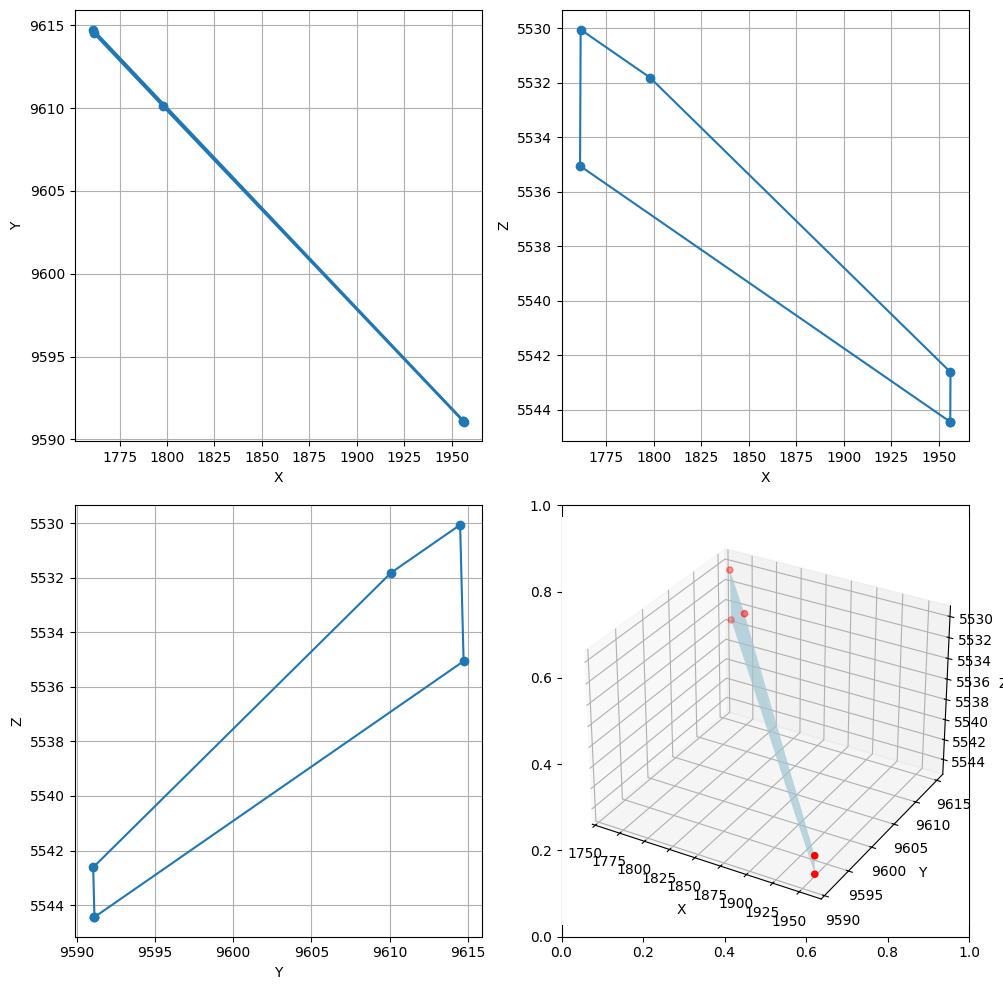

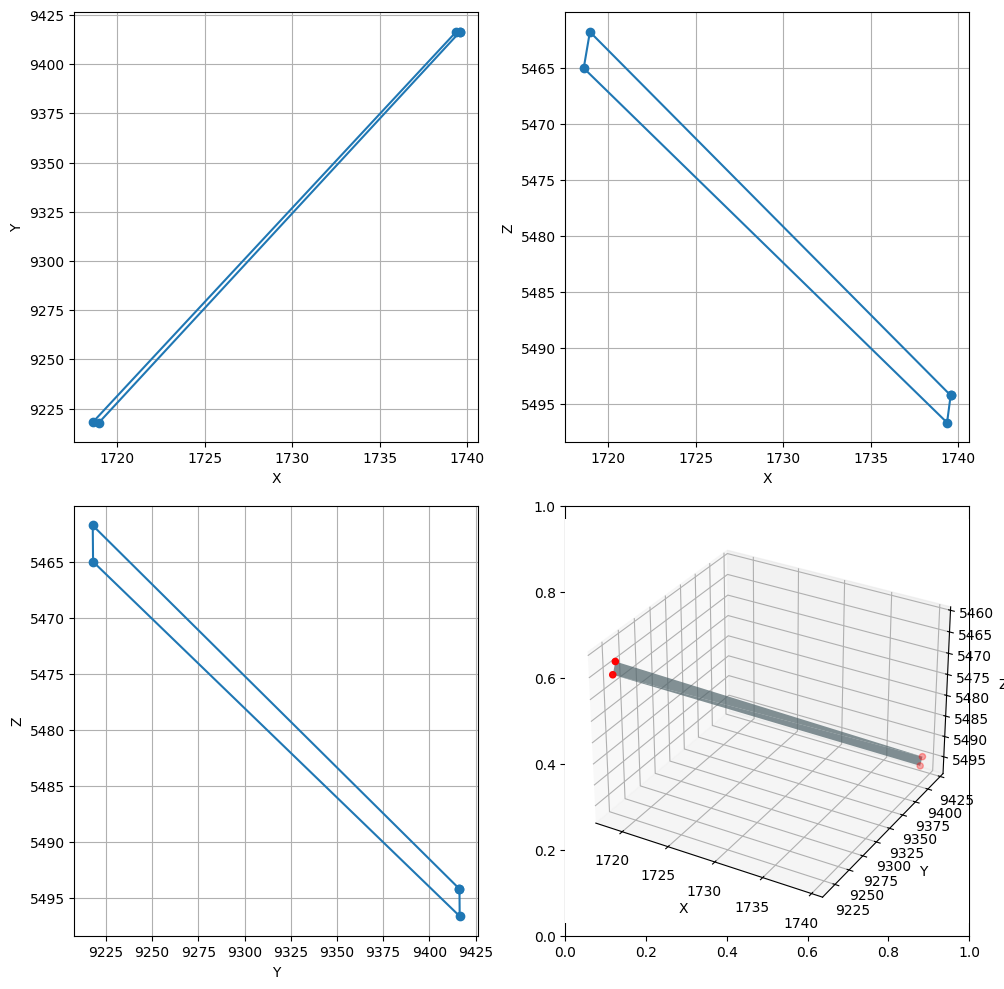

In [ ]:
def plot_plane(coordinates):
    fig, axis = plt.subplots(2, 2, figsize=(10, 10))
    axis = axis.flatten()

    def plot_face(ax, coordinates, x_axis=0, y_axis=1,
                  x_axis_label='X', y_axis_label='Y'):
        closed_coordinates = np.vstack([coordinates, coordinates[0]])
        ax.plot(closed_coordinates[:, x_axis], closed_coordinates[:, y_axis], marker='o')
        ax.set_xlabel(x_axis_label)
        ax.set_ylabel(y_axis_label)
        if y_axis_label[0].upper() == "Z":
            ax.invert_yaxis()
        ax.grid(True)

    x_axis = [0, 0, 1]
    y_axis = [1, 2, 2]
    x_axis_label = ['X', 'X', 'Y']
    y_axis_label = ['Y', 'Z', 'Z']

    for x, y, x_label, y_label, ax in zip(x_axis, y_axis, x_axis_label, y_axis_label, axis[:3]):
        plot_face(ax, coordinates, x, y, x_label, y_label)

    # Create a 3D subplot
    ax_3d = fig.add_subplot(2, 2, 4, projection='3d')

    # Extract x, y, and z coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]

    ax_3d.plot_trisurf(x, y, z, color='lightblue', alpha=0.7)
    ax_3d.scatter(x, y, z, color='red', marker='o')

    ax_3d.invert_zaxis()

    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

coordinates = _get_common_face(connections[5]) #_get_nodes([4], "I-")[0]
plot_plane(coordinates)
coordinates = _get_nodes([4], "I-")[0]
plot_plane(coordinates)